In [1]:
from google.colab import userdata
git_token=userdata.get('git_token')
groq_token=userdata.get('groq_token')

In [2]:
!pip install Groq pygithub javalang jpype1
!wget -q https://repo1.maven.org/maven2/com/github/javaparser/javaparser-core/3.25.4/javaparser-core-3.25.4.jar -O javaparser-core.jar

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.9/124.9 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.1/494.1 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 856.7/856.7 kB 13.4 MB/s eta 0:00:00


In [4]:
from github import Github

g = Github(git_token)
repo = g.get_repo("lx-47/todo-spring")
files = {}

def get_all_files(path):
    contents = repo.get_contents(path, "main")
    for i in contents:
        if i.type == "dir":
            get_all_files(i.path)
        else:
            files[i.path] = i.decoded_content.decode("utf-8") if i.path.endswith(".java") else ""

get_all_files("")



In [18]:
for path, contents in files.items():
  print(path,contents)

HELP.md 
README.md 
mvnw 
mvnw.cmd 
pom.xml 
src/main/java/com/example/todo/Mapper/TodoMapper.java package com.example.todo.Mapper;


import com.example.todo.dto.TodoResponse;
import com.example.todo.entity.TodoEntity;

public class TodoMapper {
    public static TodoResponse todoResponse(TodoEntity todoEntity){
        return new TodoResponse(
                todoEntity.getId(),
                todoEntity.getTitle(),
                todoEntity.getDescription(),
                todoEntity.isCompleted(),
                todoEntity.getCreatedAt()
        );
    }
}

src/main/java/com/example/todo/TodoApplication.java package com.example.todo;

import org.springframework.boot.SpringApplication;
import org.springframework.boot.autoconfigure.SpringBootApplication;

@SpringBootApplication
public class TodoApplication {

	public static void main(String[] args) {
		SpringApplication.run(TodoApplication.class, args);
	}

}

src/main/java/com/example/todo/controller/TodoController.java package c

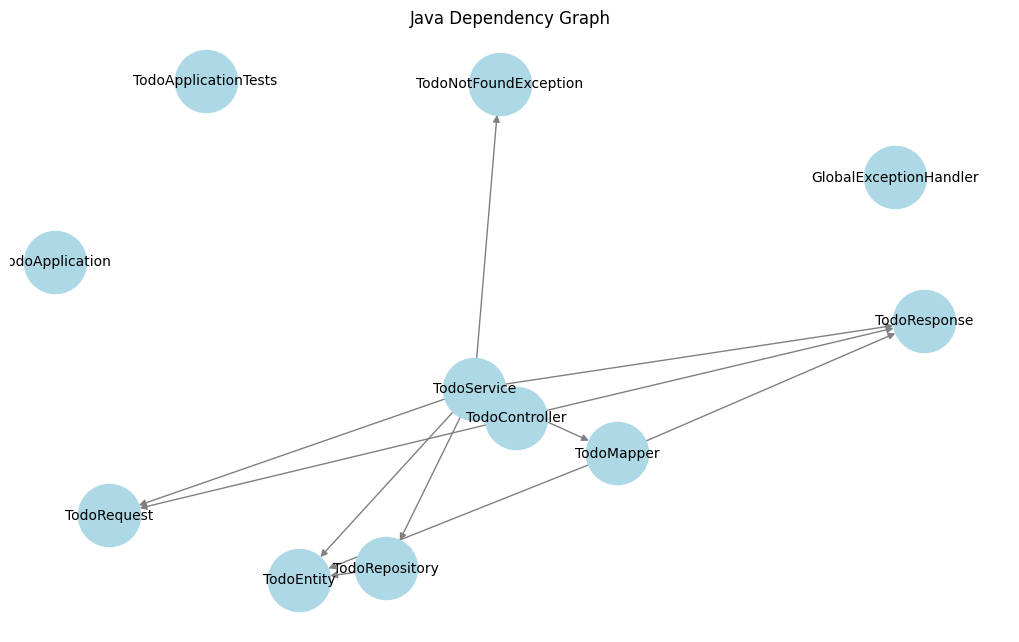

In [16]:
import re
import networkx as nx
import matplotlib.pyplot as plt

# Dictionary `files` already contains Java file paths and their content
# files = { "path/to/File1.java": "content...", "path/to/File2.java": "content..." }

dependency_graph = nx.DiGraph()

# Regex patterns
class_pattern = re.compile(r'\b(class|interface|enum)\s+(\w+)')
import_pattern = re.compile(r'^import\s+([\w.]+);', re.MULTILINE)

# Step 1: Extract class names
class_map = {}  # Map file paths to class names
for path, content in files.items():
    match = class_pattern.search(content)
    if match:
        class_name = match.group(2)
        class_map[path] = class_name
        dependency_graph.add_node(class_name)  # Add as a node

# Step 2: Extract imports and build edges
for path, content in files.items():
    if path in class_map:
        class_name = class_map[path]
        imports = import_pattern.findall(content)

        for imp in imports:
            imported_class = imp.split('.')[-1]  # Get simple class name

            # Check if it's an internal dependency
            if imported_class in class_map.values():
                dependency_graph.add_edge(class_name, imported_class)

# Step 3: Visualize the graph
plt.figure(figsize=(10, 6))
nx.draw(dependency_graph, with_labels=True, node_color="lightblue", edge_color="gray", node_size=2000, font_size=10)
plt.title("Java Dependency Graph")
plt.show()


In [5]:
import javalang

project_summary = {}

def extract_class_info(java_code):
    """Extracts class details, methods, dependencies, and annotations."""
    tree = javalang.parse.parse(java_code)
    class_info = {}

    for _, node in tree:
        if isinstance(node, javalang.tree.ClassDeclaration):
            class_info["name"] = node.name
            class_info["extends"] = node.extends.name if node.extends else None
            class_info["implements"] = [impl.name for impl in node.implements] if node.implements else []
            class_info["methods"] = []
            class_info["fields"] = []
            class_info["dependencies"] = []
            class_info["annotations"] = []

        if isinstance(node, javalang.tree.MethodDeclaration):
            method_summary = {
                "name": node.name,
                "return_type": node.return_type.name if node.return_type else "void",
                "parameters": [(param.type.name, param.name) for param in node.parameters],
            }
            class_info["methods"].append(method_summary)

        if isinstance(node, javalang.tree.FieldDeclaration):
            for declarator in node.declarators:
                class_info["fields"].append({"type": node.type.name, "name": declarator.name})

        if isinstance(node, javalang.tree.MethodInvocation):
            class_info["dependencies"].append(node.member)

        if isinstance(node, javalang.tree.Annotation):
            class_info["annotations"].append(node.name)

    return class_info

class_summaries = []

for path, content in files.items():
    try:
        summary = extract_class_info(content)
        class_summaries.append(summary)
        project_summary[path] = summary
    except Exception as e:
        print(f"Error parsing {path}: {e}")



In [17]:
for file_path, summary in project_summary.items():
    print("\n" + "="*50)
    print(f"📌 File: {file_path}")
    print("="*50)

    # Print Class Name
    print(f"🔹 Class: {summary.get('name', 'Unknown')}")

    # Print Class Inheritance
    if summary.get("extends"):
        print(f"🔸 Extends: {summary['extends']}")
    if summary.get("implements"):
        print(f"🔸 Implements: {', '.join(summary['implements'])}")

    # Print Fields (Instance Variables)
    print("\n🟢 Fields:")
    for field in summary.get("fields", []):
        print(f"   - {field['type']} {field['name']}")

    # Print Methods
    print("\n🟡 Methods:")
    for method in summary.get("methods", []):
        param_str = ", ".join([f"{ptype} {pname}" for ptype, pname in method.get("parameters", [])])
        print(f"   - {method['return_type']} {method['name']}({param_str})")

    # Print Dependencies (Referenced Classes)
    print("\n🔴 Dependencies:")
    for dep in summary.get("dependencies", []):
        print(f"   - {dep}")

    # Print Annotations
    print("\n🟣 Annotations:")
    for annotation in summary.get("annotations", []):
        print(f"   - @{annotation}")

    print("="*50)



📌 File: HELP.md
🔹 Class: Unknown

🟢 Fields:

🟡 Methods:

🔴 Dependencies:

🟣 Annotations:

📌 File: README.md
🔹 Class: Unknown

🟢 Fields:

🟡 Methods:

🔴 Dependencies:

🟣 Annotations:

📌 File: mvnw
🔹 Class: Unknown

🟢 Fields:

🟡 Methods:

🔴 Dependencies:

🟣 Annotations:

📌 File: mvnw.cmd
🔹 Class: Unknown

🟢 Fields:

🟡 Methods:

🔴 Dependencies:

🟣 Annotations:

📌 File: pom.xml
🔹 Class: Unknown

🟢 Fields:

🟡 Methods:

🔴 Dependencies:

🟣 Annotations:

📌 File: src/main/java/com/example/todo/Mapper/TodoMapper.java
🔹 Class: TodoMapper

🟢 Fields:

🟡 Methods:
   - TodoResponse todoResponse(TodoEntity todoEntity)

🔴 Dependencies:
   - getId
   - getTitle
   - getDescription
   - isCompleted
   - getCreatedAt

🟣 Annotations:

📌 File: src/main/java/com/example/todo/TodoApplication.java
🔹 Class: TodoApplication

🟢 Fields:

🟡 Methods:
   - void main(String args)

🔴 Dependencies:
   - run

🟣 Annotations:
   - @SpringBootApplication

📌 File: src/main/java/com/example/todo/controller/TodoController.java